In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA




In [4]:
# Load datasets
dataseta = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/b3.csv')
datasetb = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/datasetb.csv')

In [5]:

# Ensure 'cell' columns are of the same data type in both datasets
dataseta['cell'] = dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

# Align datasets by 'cell'
# Inner join ensures only matching rows are kept
combined_dataset = pd.merge(dataseta, datasetb, on='cell')

# Define the enhanced SMILES encoding function correctly
def enhanced_encode_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol),
                Descriptors.NumRotatableBonds(mol), AllChem.CalcTPSA(mol), len(mol.GetRingInfo().AtomRings())]
    else:
        return [0] * 7

# Apply enhanced SMILES encoding to the combined dataset
combined_dataset['drug1_features'] = combined_dataset['drug1'].apply(enhanced_encode_smiles)
combined_dataset['drug2_features'] = combined_dataset['drug2'].apply(enhanced_encode_smiles)

# Process the features and PCA as before
features_combined = pd.DataFrame(np.concatenate((combined_dataset['drug1_features'].tolist(), combined_dataset['drug2_features'].tolist()), axis=1),
                                  columns=['MolWt1', 'MolLogP1', 'NumHAcceptors1', 'NumHDonors1', 'NumRotatableBonds1', 'TPSA1', 'RingCount1',
                                           'MolWt2', 'MolLogP2', 'NumHAcceptors2', 'NumHDonors2', 'NumRotatableBonds2', 'TPSA2', 'RingCount2'])

In [6]:
# Assuming the 'label' column is in 'dataseta', adjust if it's otherwise
y = combined_dataset['label'].values

In [7]:
# Normalize and PCA on gene expression data
scaler = StandardScaler()
gene_expression_data = combined_dataset.drop(columns=['cell', 'drug1', 'drug2', 'drug1_features', 'drug2_features', 'label'])  # Adjust as necessary to drop non-gene expression columns
gene_expression_scaled = scaler.fit_transform(gene_expression_data)
pca = PCA(n_components=0.95)
gene_expression_pca = pca.fit_transform(gene_expression_scaled)

In [8]:

# Combine PCA components with molecular features
X = np.concatenate([gene_expression_pca, features_combined.values], axis=1)
y = dataseta['label'].values
# The rest of the modeling code remains the same


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [11]:
# Define and train the stacking model
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=32)),
    ('ada', AdaBoostClassifier(n_estimators=200, random_state=32))
]

In [12]:
meta_learner = LogisticRegression(random_state=42)
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
stacking_model.fit(X_smote, y_smote)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=32)),
                               ('ada',
                                AdaBoostClassifier(n_estimators=200,
                                                   random_state=32))],
                   final_estimator=LogisticRegression(random_state=42))

In [13]:
# Model evaluation
predictions = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.95


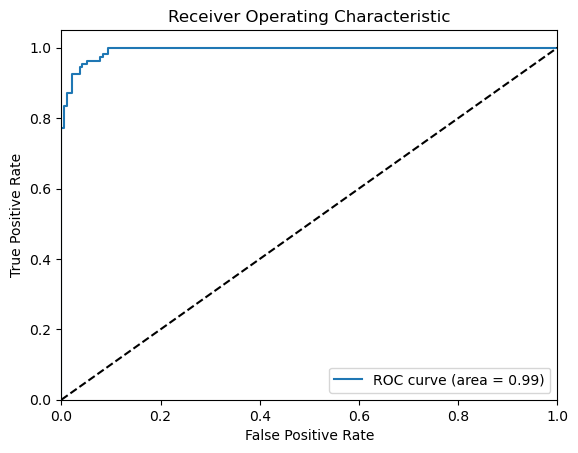

In [14]:
# ROC-AUC Curve
predictions_proba = stacking_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, predictions_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [15]:
# Assuming `stacking_model` is your trained model and you've defined X_test and y_test
# Generate predictions for the test set
predictions = stacking_model.predict(X_test)

# Generate the classification report
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test, predictions, target_names=['Class 0', 'Class 1'])

# Print the classification report
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96       191
     Class 1       0.94      0.93      0.93       109

    accuracy                           0.95       300
   macro avg       0.95      0.94      0.95       300
weighted avg       0.95      0.95      0.95       300



In [16]:
rf_importances = stacking_model.named_estimators_['rf'].feature_importances_
# Assuming the first part of X is PCA components and the second part is molecular features
features = [f'PCA_Component_{i+1}' for i in range(gene_expression_pca.shape[1])] + features_combined.columns.tolist()
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': rf_importances}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


               Feature  Importance
1      PCA_Component_2    0.362113
2      PCA_Component_3    0.281890
0      PCA_Component_1    0.139031
3               MolWt1    0.021302
9           RingCount1    0.020496
11            MolLogP2    0.019597
8                TPSA1    0.019465
4             MolLogP1    0.019241
7   NumRotatableBonds1    0.018699
6          NumHDonors1    0.016091
10              MolWt2    0.014099
5       NumHAcceptors1    0.013751
15               TPSA2    0.012082
12      NumHAcceptors2    0.011958
16          RingCount2    0.011943
14  NumRotatableBonds2    0.009879
13         NumHDonors2    0.008364


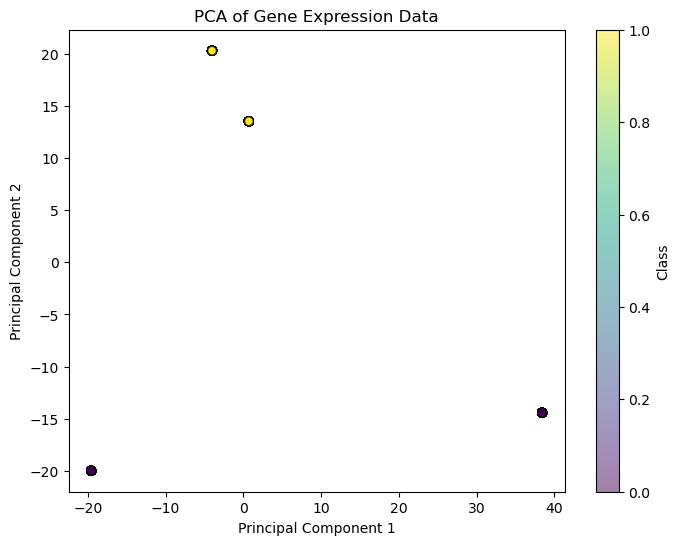

In [17]:
import matplotlib.pyplot as plt

# Plot the first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(gene_expression_pca[:, 0], gene_expression_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=40, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Gene Expression Data')
plt.colorbar(label='Class')
plt.show()
